# Maximum Mean Discrepancy drift detector on CIFAR-10

### Method

The [Maximum Mean Discrepancy (MMD)](http://jmlr.csail.mit.edu/papers/v13/gretton12a.html) detector is a kernel-based method for multivariate 2 sample testing. The MMD is a distance-based measure between 2 distributions *p* and *q* based on the mean embeddings $\mu_{p}$ and $\mu_{q}$ in a reproducing kernel Hilbert space $F$:

$$
MMD(F, p, q) = || \mu_{p} - \mu_{q} ||^2_{F}
$$

We can compute unbiased estimates of $MMD^2$ from the samples of the 2 distributions after applying the kernel trick. We use by default a [radial basis function kernel](https://en.wikipedia.org/wiki/Radial_basis_function_kernel), but users are free to pass their own kernel of preference to the detector. We obtain a $p$-value via a [permutation test](https://en.wikipedia.org/wiki/Resampling_(statistics)) on the values of $MMD^2$. This method is also described in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/abs/1810.11953).

### Backend

The method is implemented in both the *PyTorch* and *TensorFlow* frameworks with support for CPU and GPU. Various preprocessing steps are also supported out-of-the box in Alibi Detect for both frameworks and illustrated throughout the notebook. Alibi Detect does however not install PyTorch for you. Check the [PyTorch docs](https://pytorch.org/) how to do this. 

### Dataset

[CIFAR10](https://www.cs.toronto.edu/~kriz/cifar.html) consists of 60,000 32 by 32 RGB images equally distributed over 10 classes. We evaluate the drift detector on the CIFAR-10-C dataset ([Hendrycks & Dietterich, 2019](https://arxiv.org/abs/1903.12261)). The instances in
CIFAR-10-C have been corrupted and perturbed by various types of noise, blur, brightness etc. at different levels of severity, leading to a gradual decline in the classification model performance. We also check for drift against the original test set with class imbalances. 

In [1]:
from functools import partial
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from alibi_detect.cd import MMDDrift
from alibi_detect.models.tensorflow.resnet import scale_by_instance
from alibi_detect.utils.fetching import fetch_tf_model
from alibi_detect.utils.saving import save_detector, load_detector
from alibi_detect.datasets import fetch_cifar10c, corruption_types_cifar10c
#from alibi_detect.factory import DetectorFactory

Importing plotly failed. Interactive plots will not work.


### Load data

Original CIFAR-10 data:

In [2]:
(X_train, y_train), (X_test, y_test) = tf.keras.datasets.cifar10.load_data()
X_train = X_train.astype('float32') / 255
X_test = X_test.astype('float32') / 255
y_train = y_train.astype('int64').reshape(-1,)
y_test = y_test.astype('int64').reshape(-1,)

For CIFAR-10-C, we can select from the following corruption types at 5 severity levels:

In [3]:
corruptions = corruption_types_cifar10c()
print(corruptions)

['brightness', 'contrast', 'defocus_blur', 'elastic_transform', 'fog', 'frost', 'gaussian_blur', 'gaussian_noise', 'glass_blur', 'impulse_noise', 'jpeg_compression', 'motion_blur', 'pixelate', 'saturate', 'shot_noise', 'snow', 'spatter', 'speckle_noise', 'zoom_blur']


Let's pick a subset of the corruptions at corruption level 5. Each corruption type consists of perturbations on all of the original test set images.

In [4]:
corruption = ['motion_blur']
X_corr, y_corr = fetch_cifar10c(corruption=corruption, severity=3, return_X_y=True)
X_corr = X_corr.astype('float32') / 255

We split the original test set in a reference dataset and a dataset which should not be rejected under the *H<sub>0</sub>* of the MMD test. We also split the corrupted data by corruption type:

In [5]:
np.random.seed(0)
n_test = X_test.shape[0]
idx = np.random.choice(n_test, size=n_test // 2, replace=False)
idx_h0 = np.delete(np.arange(n_test), idx, axis=0)
X_ref,y_ref = X_test[idx], y_test[idx]
X_h0, y_h0 = X_test[idx_h0], y_test[idx_h0]
print(X_ref.shape, X_h0.shape)

(5000, 32, 32, 3) (5000, 32, 32, 3)


In [6]:
# check that the classes are more or less balanced
classes, counts_ref = np.unique(y_ref, return_counts=True)
counts_h0 = np.unique(y_h0, return_counts=True)[1]
print('Class Ref H0')
for cl, cref, ch0 in zip(classes, counts_ref, counts_h0):
    assert cref + ch0 == n_test // 10
    print('{}     {} {}'.format(cl, cref, ch0))

Class Ref H0
0     472 528
1     510 490
2     498 502
3     492 508
4     501 499
5     495 505
6     493 507
7     501 499
8     516 484
9     522 478


In [7]:
n_corr = len(corruption)
X_c = [X_corr[i * n_test:(i + 1) * n_test] for i in range(n_corr)]

We can visualise the same instance for each corruption type:

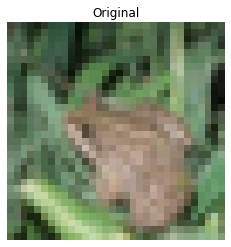

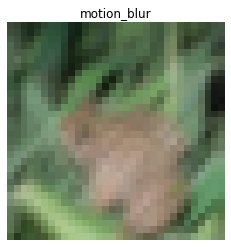

In [8]:
i = 4

n_test = X_test.shape[0]
plt.title('Original')
plt.axis('off')
plt.imshow(X_test[i])
plt.show()
for _ in range(len(corruption)):
    plt.title(corruption[_])
    plt.axis('off')
    plt.imshow(X_corr[n_test * _+ i])
    plt.show()

### Detect drift with TensorFlow backend

First we try a drift detector using the *TensorFlow* framework for both the preprocessing and the *MMD* computation steps.

We are trying to detect data drift on high-dimensional (*32x32x3*) data using a multivariate MMD permutation test. It therefore makes sense to apply dimensionality reduction first. Some dimensionality reduction methods also used in [Failing Loudly: An Empirical Study of Methods for Detecting Dataset Shift](https://arxiv.org/pdf/1810.11953.pdf) are readily available: a randomly initialized encoder (**UAE** or Untrained AutoEncoder in the paper), **BBSDs** (black-box shift detection using the classifier's softmax outputs) and **PCA** (using `scikit-learn`).

#### TEST 1: Random encoder (spec registry in config)

First we try the randomly initialized encoder:

In [9]:
from tensorflow.keras.layers import Conv2D, Dense, Flatten, InputLayer, Reshape
from alibi_detect.cd.tensorflow import preprocess_drift

tf.random.set_seed(0)

# define encoder
encoding_dim = 32
encoder_net = tf.keras.Sequential(
  [
      InputLayer(input_shape=(32, 32, 3)),
      Conv2D(64, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(128, 4, strides=2, padding='same', activation=tf.nn.relu),
      Conv2D(512, 4, strides=2, padding='same', activation=tf.nn.relu),
      Flatten(),
      Dense(encoding_dim,)
  ]
)

# define preprocessing function
preprocess_fn = partial(preprocess_drift, model=encoder_net, batch_size=512)

# initialise drift detector
cd = MMDDrift(X_ref, backend='tensorflow', p_val=.05, 
              preprocess_fn=preprocess_fn, n_permutations=100)

In [10]:
filepath = 'test'
cd.get_config('test')

{'x_ref': 'test/x_ref.npy',
 'backend': 'tensorflow',
 'preprocess': {'model': 'test/model/encoder.h5', 'batch_size': 512},
 'detector': {'detector_type': 'MMDDriftTF',
  'p_val': 0.05,
  'preprocess_x_ref': False,
  'update_x_ref': None,
  'sigma': 0.07835352420806885,
  'configure_kernel_from_x_ref': True,
  'n_permutations': 100,
  'input_shape': [32, 32, 3]},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.7.3dev',
  'backend': 'tensorflow'}}

In [11]:
cd.save_config(filepath)

In [12]:
tuple(list((1,2,3)))

(1, 2, 3)

In [13]:
from ruamel.yaml import YAML
from pathlib import Path
yaml=YAML(typ="safe")
test = yaml.load(Path('test/config.yaml'))
test

{'x_ref': 'test/x_ref.npy',
 'backend': 'tensorflow',
 'preprocess': {'model': 'test/model/encoder.h5', 'batch_size': 512},
 'detector': {'detector_type': 'MMDDriftTF',
  'p_val': 0.05,
  'preprocess_x_ref': False,
  'update_x_ref': None,
  'sigma': 0.07835352420806885,
  'configure_kernel_from_x_ref': True,
  'n_permutations': 100,
  'input_shape': [32, 32, 3]},
 'meta': {'name': 'MMDDriftTF',
  'detector_type': 'offline',
  'data_type': None,
  'version': '0.7.3dev',
  'backend': 'tensorflow'}}

In [14]:
dir(cd._detector)

['__abstractmethods__',
 '__class__',
 '__delattr__',
 '__dict__',
 '__dir__',
 '__doc__',
 '__eq__',
 '__format__',
 '__ge__',
 '__getattribute__',
 '__gt__',
 '__hash__',
 '__init__',
 '__init_subclass__',
 '__le__',
 '__lt__',
 '__module__',
 '__ne__',
 '__new__',
 '__reduce__',
 '__reduce_ex__',
 '__repr__',
 '__setattr__',
 '__sizeof__',
 '__slots__',
 '__str__',
 '__subclasshook__',
 '__weakref__',
 '_abc_impl',
 '_meta',
 'get_config',
 'infer_sigma',
 'input_shape',
 'k_xx',
 'kernel',
 'kernel_matrix',
 'meta',
 'n',
 'n_permutations',
 'p_val',
 'predict',
 'preprocess',
 'preprocess_fn',
 'preprocess_x_ref',
 'score',
 'update_x_ref',
 'x_ref']

In [15]:
cd.

SyntaxError: invalid syntax (<ipython-input-15-4d657136766b>, line 1)